# 2states Hidden Markov Model with descrete sampling in pymc3

In [1]:
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [3]:
import theano
import theano.tensor as tt
import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [4]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [5]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.15.4
Running on theano: v1.0.4
Running on PYMC3: v3.6


In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [7]:
%pylab inline

plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/jhub/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
cwd = os.getcwd()
cwd

'/home/meysam/Hidden-Markov-Models'

The transition matrix used to generate it:

[[0.9, 0.1], 
 [0.3, 0.7]]


In [9]:
data_states = np.loadtxt('SimulatedN2states.txt')
measurement= np.loadtxt('SimulatedMeasurementN2states.txt')

In [10]:
data_states.shape, measurement.shape

((1000,), (1000,))

In [11]:
Nt=len(measurement)

In [12]:
Nt

1000

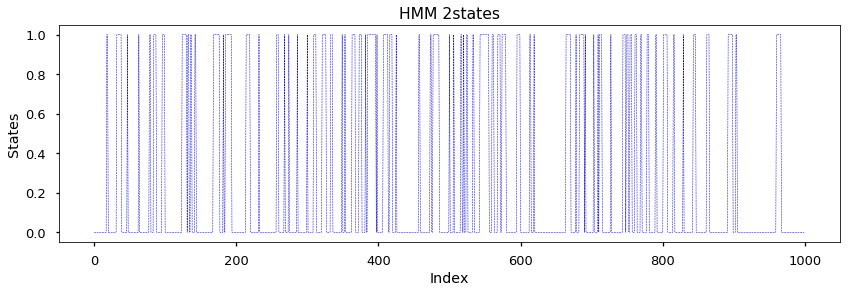

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(data_states, '--', color='mediumblue', linewidth=.5)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
#plt.savefig(os.path.join(cwd+"/Figs","Datastates_N2states.png"))
plt.show()

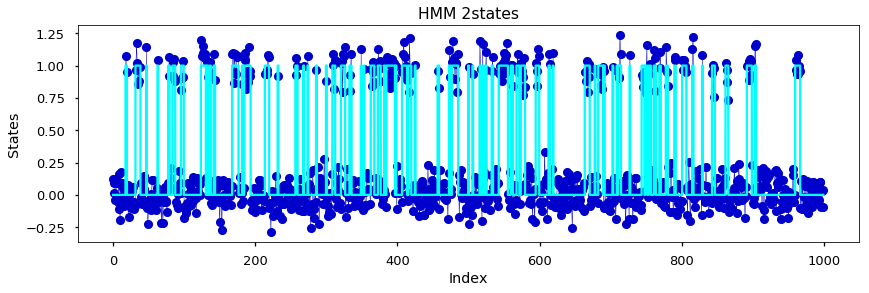

In [14]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[:Nt], '-o', color='mediumblue', linewidth=.5)
plt.plot(data_states[:Nt], drawstyle='steps-mid', color='cyan')
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
#plt.savefig(os.path.join(cwd+"/Figs","SimulatedMeasurement_N2states.png"))
plt.show()

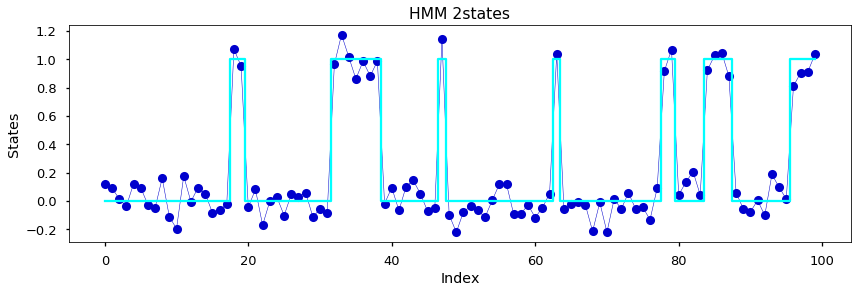

In [15]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[:100], '-o', color='mediumblue', linewidth=.5)
plt.plot(data_states[:100], drawstyle='steps-mid', color='cyan')
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
#plt.savefig(os.path.join(cwd+"/Figs","SimulatedMeasurement_N2states_zoom.png"))
plt.show()

In [13]:

class HMM2States(pm.Discrete):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P1 : tensor
        probability to remain in state 1
    P2 : tensor
        probability to move from state 2 to state 1
    
    """

    def __init__(self, PA=None, P1=None, P2=None,
                 *args, **kwargs):
        super(HMM2States, self).__init__(*args, **kwargs)
        self.PA = PA
        self.P1 = P1
        self.P2 = P2
        self.k = 2 # two state model
        self.mean = 0.
        self.mode = tt.cast(0,dtype='int64')

        
    def logp(self, x): 
        PA = self.PA
        P1 = self.P1
        P2 = self.P2
        
        PT = tt.stack((P1,P2))          
        PS = PT[x[:-1]]     
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(PS, shape=(Nt-1,2)).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [14]:
# Two state model for simplicity.
N_states = 2

In [15]:
# Transition probability stochastic
theta = np.ones(N_states) + 1.

In [16]:
theta

array([2., 2.])

### Nuts Sampling

In [ ]:
basic_model = pm.Model()

with basic_model:

    P1 = pm.Dirichlet('P1', a=theta)
    P2 = pm.Dirichlet('P2', a=theta)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMM2States('states',PA,P1,P2, observed=measurement, shape=Nt)
    

In [23]:
from pymc3.backends import SQLite , Text

In [24]:
NUTS_KWARGS={'tarhet_accept':0.99, 'max_treedepth': 10.}

In [25]:
with basic_model:
    db=pm.backends.Text('trace_nuts')
    trace_nuts = pm.sample(draws=2000, tune=10000, nuts_kwarg=NUTS_KWARGS, trace_nuts=db, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P2, P1]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:34<00:00, 1380.99draws/s]


In [26]:
filename='data_output_HMM2states_InferringStates_Nuts'
if filename in os.listdir(cwd):
    print('Directory Exists')
if not os.path.exists(os.path.join(cwd, filename)):
    try:
        os.mkdir(os.path.join(cwd, filename))
    except OSError as exception:
            if exception.errno !=errno.EEXIST:
                raise

In [27]:
directory_nuts=os.path.join(cwd, str(filename))
directory_nuts

'/home/meysam/Hidden-Markov-Models/data_output_HMM2states_InferringStates_Nuts'

In [28]:
pm.backends.text.dump(directory_nuts, trace_nuts, chains=None)

In [29]:
with basic_model:
     trace_nuts=pm.backends.text.load(directory_nuts)

In [30]:
print(trace_nuts.varnames)

['P1_stickbreaking__', 'P2_stickbreaking__', 'P1', 'P2', 'PA']


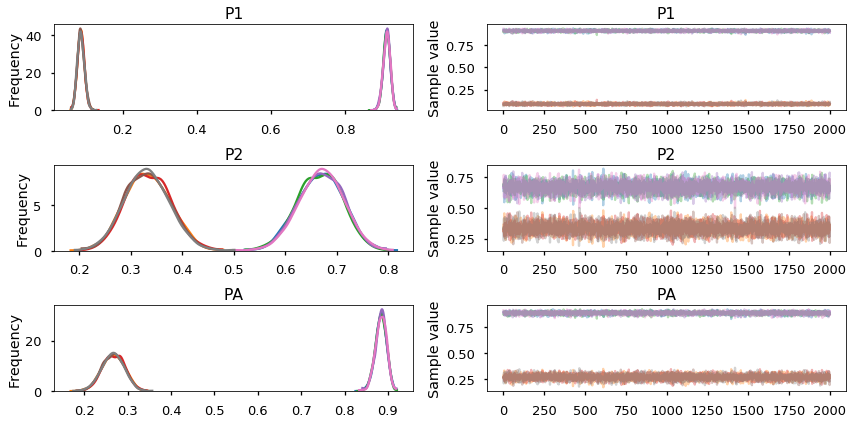

In [31]:
pm.traceplot(trace_nuts)
plt.savefig(os.path.join(cwd+"/Figs","EstimatedParams_HMM2states_InferringStates_Nuts.png"))
plt.show()

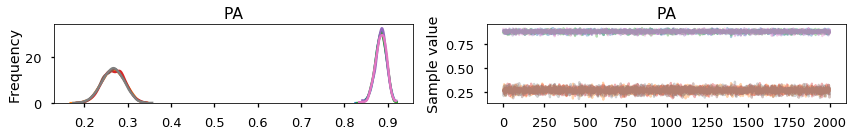

In [32]:
pm.traceplot(trace_nuts, varnames=['PA']);

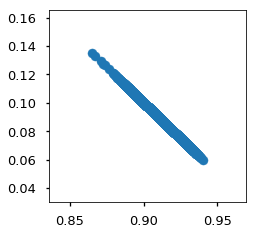

In [35]:
pm.pairplot(trace_nuts, varnames=['P1', 'P2'], divergences=True);

In [36]:
P1_est=np.asarray(trace_nuts.get_values('P1', burn=0, combine=True))
P2_est=np.asarray(trace_nuts.get_values('P2', burn=0, combine=True))
PA_est=np.asarray(trace_nuts.get_values('PA', burn=0, combine=True))

In [37]:
P1_est.shape

(8000, 2)

In [38]:
P1_mean=np.mean(P1_est, axis=0)
P2_mean=np.mean(P2_est, axis=0)
PA_mean=np.mean(PA_est, axis=0)

In [39]:
P1_mean, P2_mean, PA_mean

(array([0.91231794, 0.08768206]),
 array([0.66772823, 0.33227177]),
 array([0.88368059, 0.26609057]))

In [48]:
P_mean=np.stack((P1_mean, P2_mean))

In [49]:
P_th=np.array([[0.9, 0.1], [0.3, 0.7]])

In [50]:
sum(np.sqrt((P_th-P_mean)**2))

0.7600923387535081

In [40]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace_nuts, samples=200, model=basic_model)

100%|██████████| 200/200 [00:06<00:00, 36.45it/s]


In [51]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

states => [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(200, 1000)


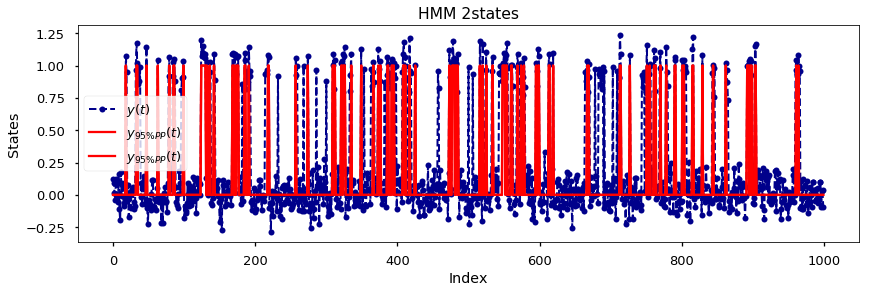

In [52]:
plt.figure(figsize=(14, 4))
plt.plot(measurement,color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['states'], [2.5, 97.5], axis=0).T, 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM2states_InferringStates_Nuts.png"))
plt.show()

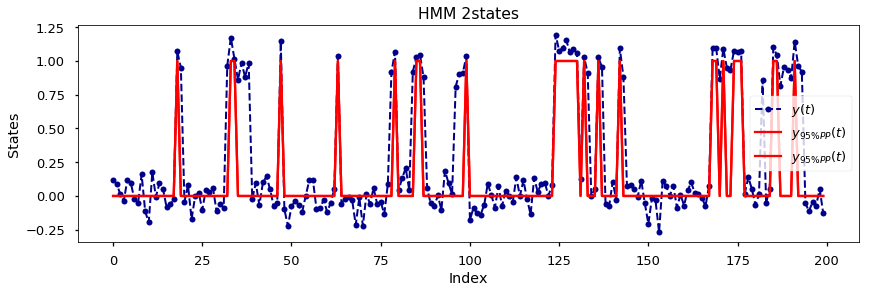

In [53]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['states'], [2.5, 97.5], axis=0).T[0:200], 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM2states_InferringStates_Nuts_zoom.png"))
plt.show()

In [54]:
trace_nuts.stat_names

set()

In [55]:
summary_nuts=pm.summary(trace_nuts).round(2)

In [56]:
summary_nuts[summary_nuts['Rhat']> 1.0]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat


In [57]:
trace_nuts_df = pm.trace_to_dataframe(trace_nuts)
print(trace_nuts_df.describe().drop('count').T)

           mean       std       min       25%       50%       75%       max
P1__0  0.912318  0.009312  0.864753  0.906347  0.912685  0.918652  0.940149
P1__1  0.087682  0.009312  0.059851  0.081348  0.087315  0.093653  0.135247
P2__0  0.667728  0.043510  0.498813  0.638200  0.668847  0.697868  0.816690
P2__1  0.332272  0.043510  0.183310  0.302132  0.331153  0.361800  0.501187
PA__0  0.883681  0.012766  0.825380  0.875531  0.884390  0.892571  0.920920
PA__1  0.266091  0.025695  0.168234  0.248579  0.266320  0.284039  0.356531


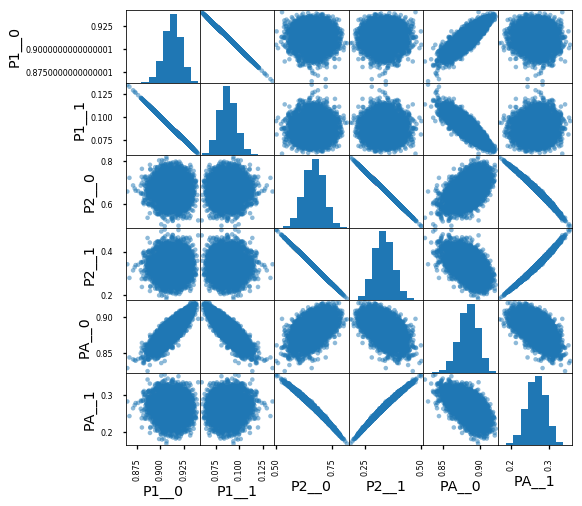

In [58]:
from pandas.plotting import scatter_matrix
scatter_matrix(trace_nuts_df, figsize=(8,8));

### Metropolis and ElemwiseCategorical Sampling

In [59]:
alphaA = 2.1
betaA = 1.1
alphaS = 2.1
betaS = 1.0

In [60]:
basic_model2 = pm.Model()

with basic_model2:
    
    P1 = pm.Dirichlet('P1', a=theta)
    P2 = pm.Dirichlet('P2', a=theta)
    
    S = pm.InverseGamma('S',alpha=alphaS, beta=betaS)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMM2States('states',PA,P1,P2, shape=Nt)
        
    emission = pm.Normal('emission',
                         mu=tt.cast(states,dtype='float64'),
                         sd=S,
                         observed = measurement)
    
    step1 = pm.Metropolis(vars=[P1, P2, S, PA, emission])
    step2 = pm.ElemwiseCategorical(vars=[states], values=[0,1])

    

/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/opt/conda/envs/jhub/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.


In [61]:
with basic_model2:
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    db_categorical=pm.backends.Text('trace_categorical')
    trace_categorical = pm.sample(draws=2000, tune=10000, step=[step1, step2],  start=start,  trace_categorical=db_categorical, chains=4)

/home/meysam/.local/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/meysam/.local/lib/python3.7/site-packages/pymc3/tuning/starting.py:102: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
  0%|          | 0/5000 [00:00<?, ?it/s]/home/meysam/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this wi

Optimization terminated successfully.
         Current function value: 739.077636
         Iterations: 2
         Function evaluations: 82


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [P2]
>>Metropolis: [P1]
>>Metropolis: [S]
>ElemwiseCategorical: [states]
Sampling 4 chains: 100%|██████████| 48000/48000 [03:53<00:00, 205.95draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [62]:
filename='data_output_HMM2states_InferringStates_Categorical'
if filename in os.listdir(cwd):
    print('Directory Exists')
if not os.path.exists(os.path.join(cwd, filename)):
    try:
        os.mkdir(os.path.join(cwd, filename))
    except OSError as exception:
            if exception.errno !=errno.EEXIST:
                raise

In [63]:
directory_categorical=os.path.join(cwd, str(filename))
directory_categorical

'/home/meysam/Hidden-Markov-Models/data_output_HMM_2states_InferringStates_Categorical'

In [64]:
pm.backends.text.dump(directory_categorical, trace_categorical, chains=None)

In [65]:
with basic_model2:
     trace_categorical=pm.backends.text.load(directory_categorical)

In [66]:
print(trace_categorical.varnames)

['P1_stickbreaking__', 'P2_stickbreaking__', 'S_log__', 'states', 'P1', 'P2', 'S', 'PA']


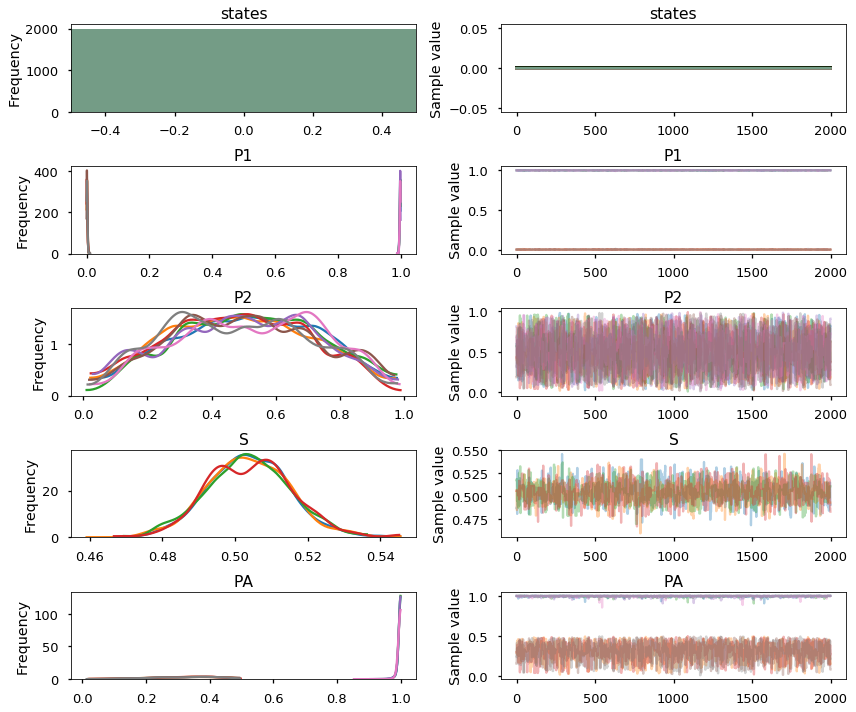

In [67]:
pm.traceplot(trace_categorical)
plt.savefig(os.path.join(cwd+"/Figs","EstimatedParams_HMM2states_InferringStates_Categorical.png"))
plt.show()

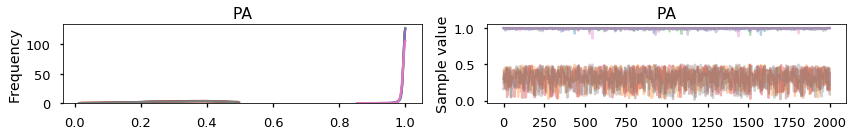

In [68]:
pm.traceplot(trace_categorical, varnames=['PA']);

/home/meysam/.local/lib/python3.7/site-packages/pymc3/plots/pairplot.py:148: UserWarning: No divergences were found.
  warnings.warn('No divergences were found.')


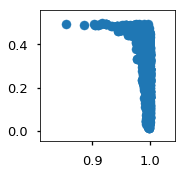

In [69]:
pm.pairplot(trace_categorical, varnames=['PA', 'P1', 'P2'], divergences=True);

In [70]:
sample_avg=np.average(trace_categorical['states'][0:],axis=0)

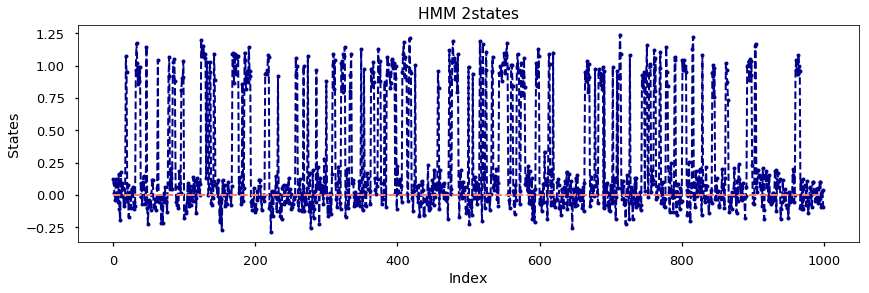

In [71]:
plt.figure(figsize=(14, 4))
plt.plot(measurement,color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=4)
plt.plot(sample_avg, color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM2states_InferringStates_Categorical.png"))
plt.show()

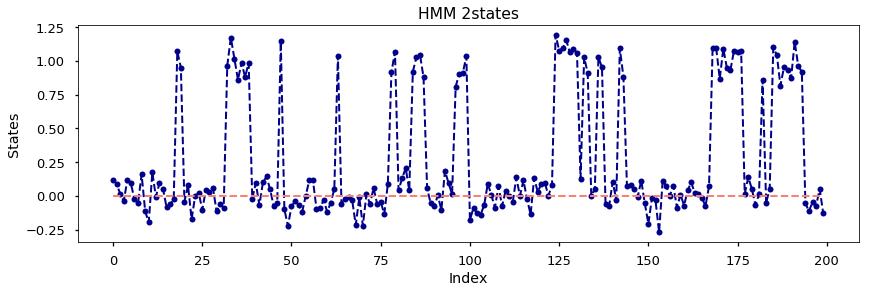

In [72]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6)
plt.plot(sample_avg[0:200], color='salmon', marker='o', linestyle='dashed',linewidth=2, markersize=.1)
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","FittedMeasurement_HMM2states_InferringStates_Categorical_zoom.png"))
plt.show()

In [73]:
P1_est=np.asarray(trace_categorical.get_values('P1', burn=0, combine=True))
P2_est=np.asarray(trace_categorical.get_values('P2', burn=0, combine=True))
S_est=np.asarray(trace_categorical.get_values('S', burn=0, combine=True))
PA_est=np.asarray(trace_categorical.get_values('PA', burn=0, combine=True))

In [74]:
P1_est.shape

(8000, 2)

In [75]:
P1_mean=np.mean(P1_est, axis=0)
P2_mean=np.mean(P2_est, axis=0)
S_mean=np.mean(S_est, axis=0)
PA_mean=np.mean(PA_est, axis=0)

In [76]:
P1_mean, P2_mean, S_mean, PA_mean

(array([0.9980663, 0.0019337]),
 array([0.5123454, 0.4876546]),
 0.5037719154393929,
 array([0.99475738, 0.31255203]))

In [77]:
P_mean=np.stack((P1_mean, P2_mean))

In [78]:
P_th=np.array([[0.9, 0.1], [0.3, 0.7]])

In [79]:
sum(np.sqrt((P_th-P_mean)**2))

0.6208234121181271

In [80]:
#generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace_categorical, samples=200, model=basic_model2)

100%|██████████| 200/200 [00:02<00:00, 89.43it/s]


In [81]:
for key,val in ppc_trace.items():
    print (key, "=>", val)
    print (val.shape)

emission => [[-0.38565486 -0.08661589  0.22062588 ...  0.1752683   0.01600048
  -0.13012098]
 [-0.36888431 -0.04791465  1.01303533 ...  0.36609362 -0.32173001
   0.77441772]
 [ 0.03557749  0.17366646 -0.1479303  ...  0.76405127  0.29581103
  -0.01432077]
 ...
 [-0.31903514 -0.08259114  0.24742585 ...  0.12873936  0.42050249
   0.07971808]
 [ 0.62383779  0.55734484 -0.29779358 ...  0.05762686  1.29342415
   0.77325429]
 [-0.26212414  0.15030202  0.73188315 ... -0.18204183  0.02183409
   0.46990162]]
(200, 1000)


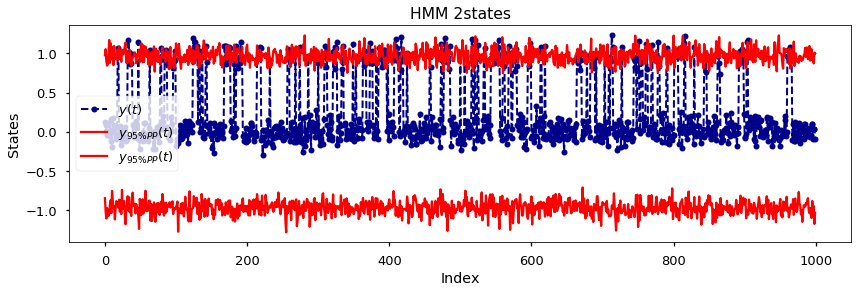

In [82]:
plt.figure(figsize=(14, 4))
plt.plot(measurement,color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['emission'], [2.5, 97.5], axis=0).T, 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states') 
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM2states_InferringStates_Categorical.png"))
plt.show()

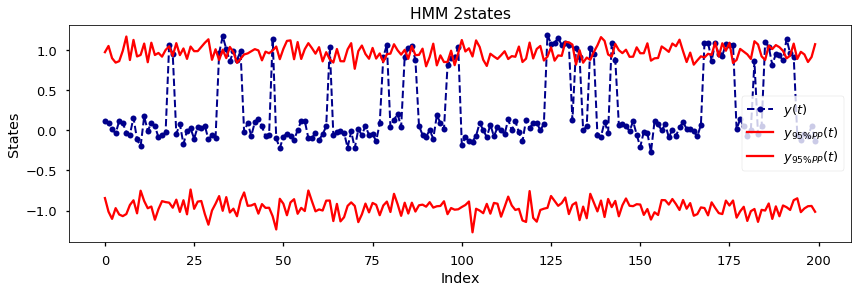

In [83]:
plt.figure(figsize=(14, 4))
plt.plot(measurement[0:200],color='darkblue', marker='o', linestyle='dashed',linewidth=2, markersize=6, label=r'$y(t)$')
plt.plot(percentile(ppc_trace['emission'], [2.5, 97.5], axis=0).T[0:200], 'r', label=r'$y_{95\% PP}(t)$')
plt.legend()
plt.xlabel('Index'); 
plt.ylabel('States'); 
plt.title('HMM 2states')
plt.savefig(os.path.join(cwd+"/Figs","PPCFittedMeasurement_HMM2states_InferringStates_Categorical_zoom.png"))
plt.show()

In [84]:
trace_categorical.stat_names

set()

In [85]:
summary_categorical=pm.summary(trace_categorical).round(2)

In [86]:
summary_categorical[summary_categorical['Rhat']> 1.0]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
